In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal

from decode_tueg import (
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, 
    create_windows, _create_windows,
    create_final_scores, _create_final_scores,
    plot_chronological_vs_predicted_age, plot_age_gap_hist,
    plot_thresh_to_acc, plot_joint_scatter, save_fig,
    load_exp, predict_ds,
)

In [3]:
base_dir = '/home/jovyan/new_full_runs/'
exps = {
#     3: '220824144139015381',
#     1: '220824191628058941',
#     4: '220824144141880751',
#     2: '220824144128724203',
    0: '220824144055632350',
}
# seeds = []  #  TODO: run multiple seeds
model = 'valid_best'  # 'train_end', 'valid_best'
n_jobs = 6

In [4]:
only_valid = True
subsets = ['normal']#, 'mixed', 'abnormal']
mem_efficient = True

In [5]:
dfs = []
for exp_i, exp in exps.items():
    clf, data_scaler, target_scaler, config = load_exp(base_dir, exp, model)
    for subset_i, subset in enumerate(subsets):
        train, valid, mapping = get_datasets(
            config.data_path,
            config.target_name,
            subset,  # maybe skip the subset used for training. could serve as sanity check though
            int(config.n_train_recordings),
            int(config.tmin),
            int(config.tmax),
            int(config.n_jobs),
            int(config.final_eval),
            float(config.valid_set_i),
            int(config.seed),
        )

        n_channels = train[0][0].shape[0]
        t = torch.ones(1, n_channels, int(config.window_size_samples), 1).cuda()
        n_preds_per_input = clf.module(t).size()[2]

        # order due to indexing ax_arr for plotting
        for ds_i, (ds_name, ds) in enumerate(
            [(test_name(int(config.final_eval)), valid), ('train', train)]):
            mean_train_age = train.description['age'].mean()
            if only_valid and ds_name == 'train':
                print("skipping train")
                continue
            preds, targets = predict_ds(
                clf,
                ds, 
                config.target_name,
                mapping,
                target_scaler,
                data_scaler,
                n_channels,
                int(config.window_size_samples),
                n_preds_per_input,
                min(n_jobs, int(config.n_jobs)),
                int(config.preload),
                mem_efficient=mem_efficient,
            )
            print(preds.shape, targets.shape)
            if config.target_name in ['age']:
                score = mean_absolute_error(targets, preds)
            else:
                score = balanced_accuracy_score(targets, preds)

            df = pd.DataFrame({
                'y_pred': preds.ravel(),
                'y_true': targets.ravel(),
                'pathological': ds.description['pathological'].to_numpy(),
                'exp': len(ds.description) * [exp],
                'subset': len(ds.description) * [subset],
                'split': len(ds.description) * [ds_name],
                'fold': len(ds.description) * [exp_i],
            })
            dfs.append(df)

2022-08-30 14:51:52 DEBUG    indexing files
2022-08-30 14:52:29 INFO     validation run, removing eval from dataset with 2993 recordings
2022-08-30 14:52:29 DEBUG    into train (0.9) and eval (0.1).
2022-08-30 14:52:29 DEBUG    splitting dataset with 2693 recordings
2022-08-30 14:52:29 DEBUG    into train (.8) and valid (.2).
2022-08-30 14:52:29 DEBUG    from train (2154) and valid (539) selecting normal
2022-08-30 14:52:30 DEBUG    selected train (1098) and valid (271)
2022-08-30 14:52:30 DEBUG    some raw durations [3023.0, 1187.0, 1147.0]
2022-08-30 14:52:30 DEBUG    preprocessing
2022-08-30 14:52:30 DEBUG    adding cropper 60 – None
2022-08-30 14:52:33 DEBUG    adding cropper 60 – None
2022-08-30 14:52:34 DEBUG    some preprocessed durations [2962.99, 1126.99, 1086.99]
2022-08-30 14:52:34 DEBUG    train datasets 1098
2022-08-30 14:52:34 DEBUG    valid datasets 271
(271,) (271,)
skipping train


In [6]:
df_concat = pd.concat(dfs).reset_index()

In [7]:
df_concat

,index,y_pred,y_true,pathological,exp,subset,split,fold
0,0,53.873322,53.000004,False,220824144055632350,normal,valid,0
1,1,43.305187,32.000000,False,220824144055632350,normal,valid,0
2,2,37.239021,39.000000,False,220824144055632350,normal,valid,0
3,3,43.747784,28.000000,False,220824144055632350,normal,valid,0
4,4,50.673134,69.000000,False,220824144055632350,normal,valid,0
...,...,...,...,...,...,...,...,...
266,266,45.348957,59.000000,False,220824144055632350,normal,valid,0
267,267,44.319000,55.000000,False,220824144055632350,normal,valid,0
268,268,51.179985,59.999996,False,220824144055632350,normal,valid,0
269,269,56.446735,59.000000,False,220824144055632350,normal,valid,0


In [8]:
#TODO: manually do the jointplot (distplot, regplot, kdeplot)
#TODO: plot the gap proxy for normal / pathological indivudally?
#TODO: update colors

In [9]:
plot_only_valid = False
this_df_concat = df_concat[df_concat.split == 'valid'] if plot_only_valid else df_concat

split valid subset normal  (271, 8)


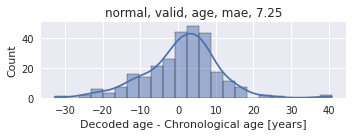

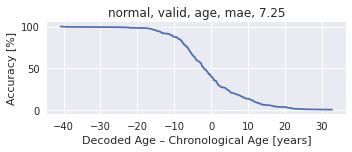

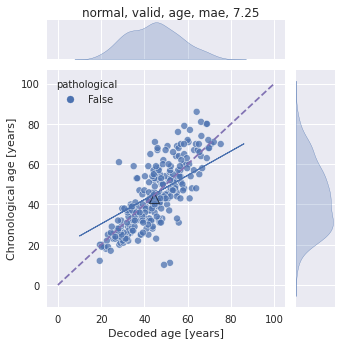

In [10]:
grouping = ['split', 'subset']#, 'fold']
splits = list(this_df_concat.split.unique())
n_splits = len(splits) 
subsets = list(this_df_concat.subset.unique())
n_subsets = len(subsets)
fig2, ax_arr2 = plt.subplots(
    n_splits, n_subsets, figsize=(5*n_subsets, 2*n_splits), squeeze=False, sharex=True)
fig3, ax_arr3 = plt.subplots(
    n_splits, n_subsets, figsize=(5*n_subsets, 2*n_splits), squeeze=False, sharex=True)
for x, df in this_df_concat.groupby(grouping):
    split_i = splits.index(x[0])
    subset_i = subsets.index(x[1])
    fold = '' if len(x) == 2 else x[2]
    print('split', x[0], 'subset', x[1], fold, df.shape)

    score_name = 'acc' if config.target_name != 'age' else 'mae'
    score = mean_absolute_error(df.y_true, df.y_pred) if config.target_name == 'age' else balanced_accuracy_score(df.y_true, df.y_pred)
    title = f"{x[1]}, {x[0]}, {config.target_name}, {score_name}, {score:.2f}"
    ax4 = plot_joint_scatter(df)
    ax4.figure.tight_layout()
    ax4.fig.subplots_adjust(top=0.94)
    ax4.fig.suptitle(title);

    ax2 = plot_age_gap_hist(
        df,
        ax=ax_arr2[split_i, subset_i],
    )
    ax2.figure.tight_layout()
    ax2.set_title(title)

    ax3 = plot_thresh_to_acc(
        df,
        ax=ax_arr3[split_i, subset_i],
    )
    ax3.figure.tight_layout()
    ax3.set_title(title)

In [5]:
# check whether age_clf lead to bimodal distribution of predictions

In [6]:
exp = '220824144254199487'
subset = 'normal'
ds_name = 'valid'
exp_i = 0

In [7]:
clf, data_scaler, target_scaler, config = load_exp(
    '/home/jovyan/outdated_runs/', exp, 'train_end')

In [8]:
train, valid, mapping = get_datasets(
    config.data_path,
    config.target_name,
    subset,
    int(config.n_train_recordings),
    int(config.tmin),
    int(config.tmax),
    int(config.n_jobs),
    int(config.final_eval),
    float(config.valid_set_i),
    int(config.seed),
)

2022-08-30 15:07:12 DEBUG    indexing files
2022-08-30 15:07:49 INFO     validation run, removing eval from dataset with 2993 recordings
2022-08-30 15:07:49 DEBUG    into train (0.9) and eval (0.1).
2022-08-30 15:07:49 DEBUG    splitting dataset with 2693 recordings
2022-08-30 15:07:49 DEBUG    into train (.8) and valid (.2).
2022-08-30 15:07:49 DEBUG    from train (2154) and valid (539) selecting normal
2022-08-30 15:07:50 DEBUG    selected train (1098) and valid (271)
2022-08-30 15:07:50 DEBUG    some raw durations [3023.0, 1187.0, 1147.0]
2022-08-30 15:07:50 DEBUG    preprocessing
2022-08-30 15:07:50 DEBUG    adding cropper 60 – None
2022-08-30 15:07:53 DEBUG    adding cropper 60 – None
2022-08-30 15:07:54 DEBUG    some preprocessed durations [2962.99, 1126.99, 1086.99]
2022-08-30 15:07:54 DEBUG    train datasets 1098
2022-08-30 15:07:54 DEBUG    valid datasets 271


In [9]:
n_channels = train[0][0].shape[0]
t = torch.ones(1, n_channels, int(config.window_size_samples), 1).cuda()
n_preds_per_input = clf.module(t).size()[2]

In [ ]:
train = None
ds = valid
preds, targets = predict_ds(
    clf, 
    ds, 
    config.target_name,
    mapping, 
    target_scaler, 
    data_scaler, 
    n_channels, 
    int(config.window_size_samples),
    n_preds_per_input,
    n_jobs, 
    config.preload, 
    mem_efficient,
)

<AxesSubplot:xlabel='Chronological Age [years]', ylabel='Decoded Age [years]'>

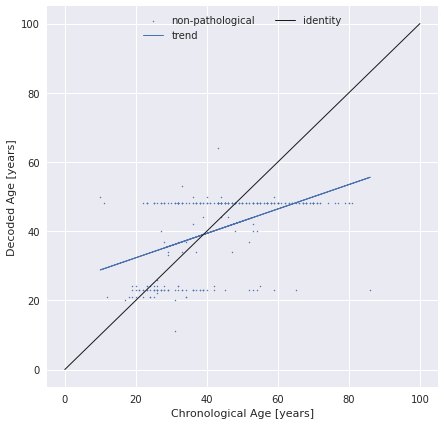

In [42]:
plot_chronological_vs_predicted_age(
    pd.DataFrame({
        'y_pred': preds.argmax(axis=-1).ravel(),
        'y_true': targets.ravel(),
        'pathological': ds.description['pathological'].to_numpy(),
        'exp': len(ds.description) * [exp],
        'subset': len(ds.description) * [subset],
        'split': len(ds.description) * [ds_name],
        'fold': len(ds.description) * [exp_i],
    })
)